# ENSF 544 Project 2 - ASL alphabet Recognition Using SVM

In [62]:
import os.path
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import math

In [63]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def calculate_distance_and_angle_features(landmarks):
    distances = []
    angles = []

    for i in range(len(landmarks)):
        landmark = landmarks[i]
        for j in range(i+1, len(landmarks)):
            other_landmark = landmarks[j]
            
            x_diff = landmark.x - other_landmark.x
            y_diff = landmark.y - other_landmark.y
            z_diff = landmark.z - other_landmark.z
            magnitude = math.sqrt(x_diff*x_diff + y_diff*y_diff + z_diff*z_diff)

            if (i, j) not in mp_hands.HAND_CONNECTIONS: 
                distances.append(magnitude)     # distance between joints
            
            angles.append(x_diff / magnitude)   # angle with x axis
            angles.append(y_diff / magnitude)   # angle with y axis
            angles.append(z_diff / magnitude)   # angle with z axis

    return distances + angles

def get_df_columns():
    df_columns = []

    # getting columns for distance features
    for i in range(21):
        for j in range(i+1, 21):
            if (i, j) in mp_hands.HAND_CONNECTIONS: continue
            df_columns.append(f"dist({i}, {j})")

    # getting columns for angle features
    for i in range(21):
        for j in range(i+1, 21):
            df_columns.append(f"cosx({i}, {j})")
            df_columns.append(f"cosy({i}, {j})")
            df_columns.append(f"cosz({i}, {j})")

    return df_columns

def load_hand_landmark_data(directory, num_imgs_per_component=100, complexity=1, min_confidence=0.5):
    hand_landmarks = pd.DataFrame(columns=get_df_columns())
    labels = []

    plt.figure(figsize=(5,6))
    i = 1

    with mp_hands.Hands(
        static_image_mode = True,
        max_num_hands = 1,
        model_complexity = complexity,
        min_detection_confidence = min_confidence
        ) as hands:

        # Iterate through each image in each subfolder
        for folder in os.listdir(directory):
            # only processing letters. Ignoring "special" characters
            if len(folder) > 1: 
                continue

            successful_image_count = 0
            for image in os.listdir(directory + "/" + folder):
                if successful_image_count == num_imgs_per_component: 
                    break

                temp_img = cv2.imread(directory + '/' + folder + '/' + image)
                if temp_img is None: 
                    continue
                temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

                result = hands.process(temp_img)
                if not result.multi_hand_landmarks: 
                    continue

                successful_image_count += 1
                last_landmark = result.multi_hand_landmarks[0]
                
                hand_landmarks.loc[len(hand_landmarks)] = calculate_distance_and_angle_features(result.multi_hand_landmarks[0].landmark)
                labels.append(folder)

            # displaying the last image of each letter
            annotated_image = temp_img.copy()
            if successful_image_count > 0:
                mp_drawing.draw_landmarks(
                    annotated_image,
                    last_landmark,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style()
                )
            plt.subplot(5, 6, i)
            plt.title(folder)
            plt.imshow(annotated_image)
            plt.xticks([])
            plt.yticks([])
            i += 1

    plt.show()
    return hand_landmarks, pd.Series(labels)


In [64]:
training_dir = "dataset/asl_alphabet_train"
test_dir = "dataset/asl_alphabet_test"

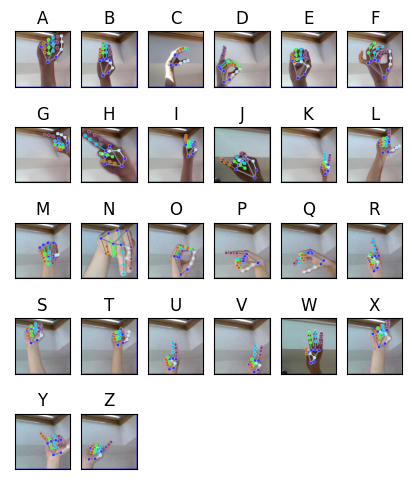

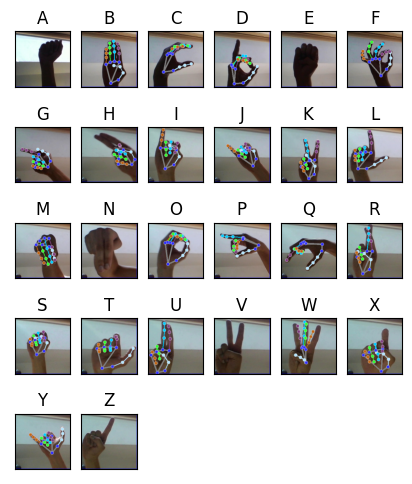

In [65]:
X_trainval, y_trainval = load_hand_landmark_data(training_dir, min_confidence=0.05)
X_test, y_test = load_hand_landmark_data(test_dir, min_confidence=0.05)

(2600, 819)